# Eleven supercase

### Clustering

In [79]:
import pandas as pd
import numpy as np

from tqdm import tqdm
tqdm.pandas()

import dask
import dask.dataframe as dd
import dask.distributed as dist

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Import data

In [2]:
sessions = (pd.read_csv('../data/sessions_with_orders.csv.gz', 
                    index_col=0,
                    parse_dates=[4, 5, 11, 13],
                    dtype={
                         'global_sources': 'category',
                         'device_type': 'category',
                         'device_model': 'category',
                         'order_channel': 'category',
                         'client_number': str
                    })
        .assign(
            duration=lambda df: pd.to_timedelta(df.duration),
            cvic=lambda df: df.cvic.fillna(0).astype(bool)
        ))

/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
sessions.head()

,session_id,visitor_id,nb_pages,session_start_date,session_end_date,global_sources,device_type,device_model,funnel,duration,session_date,client_number,order_date,order_channel,pre_tax_amount,cvic
0,0e1394681b56,706340,7,2017-08-08 12:59:55,2017-08-08 13:03:58,Moteurs,Smartphone,sm-a310f,"['accueil', 'accueil', 'recherche', 'accueil',...",00:04:03,2017-08-08,NaN,NaT,NaN,NaN,False
1,5c2fa4c1d77d,0,1,2017-08-08 19:02:31,2017-08-08 19:02:31,Moteurs,Ordinateur,NaN,['category'],00:00:00,2017-08-08,NaN,NaT,NaN,NaN,False
2,a06e8866a9fb,706610,35,2017-08-08 08:49:15,2017-08-08 09:24:32,Email marketing,Tablette,iPad,"['accueil', 'login_no_compte_internet', 'produ...",00:35:17,2017-08-08,8991549401744498771,2017-08-08,Internet,45.0,False
3,a06f692cb363,0,1,2017-08-08 11:25:19,2017-08-08 11:25:19,Publicité,Ordinateur,NaN,['accueil'],00:00:00,2017-08-08,NaN,NaT,NaN,NaN,False
4,74e6e670f013,0,1,2017-08-08 10:12:16,2017-08-08 10:12:16,Accès Direct,Ordinateur,NaN,['product'],00:00:00,2017-08-08,NaN,NaT,NaN,NaN,False


#### Visualisation (cf. 1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

We focus on sessions which have led to a conversion

In [5]:
logged_sessions = sessions[lambda df: df.client_number.notnull()].drop_duplicates()

In [6]:
X = logged_sessions[['nb_pages', 'duration', 'global_sources', 'order_date', 'device_type', 'pre_tax_amount']]
y = logged_sessions['cvic']

Let's try to encode the order date by factoring in the periodicity of the 17 catalog mails.

In [7]:
X['cycle_day'] = np.cos(X['order_date'].dt.dayofyear*(1/17)*2*np.pi)

/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
X['global_sources'] = X['global_sources'].cat.codes
X['device_type'] = X['device_type'].cat.codes
X['duration'] = X['duration'].dt.total_seconds()
X = X.drop(['order_date'], axis=1)

/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [9]:
X.head()

,nb_pages,duration,global_sources,device_type,pre_tax_amount,cycle_day
2,35,2117.0,2,4,45.00,0.932472
6,30,1368.0,2,2,146.66,0.932472
14,26,1710.0,4,1,195.50,0.932472
30,30,1689.0,2,1,141.59,0.932472
71,5,102.0,3,4,52.42,0.739009


**PCA**

In [10]:
X = StandardScaler(copy=True).fit_transform(X)

In [11]:
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X), index=logged_sessions.index)
X_pca = pd.concat([X_pca, y], axis=1)

In [12]:
pca.explained_variance_ratio_.sum()

0.651308262037873

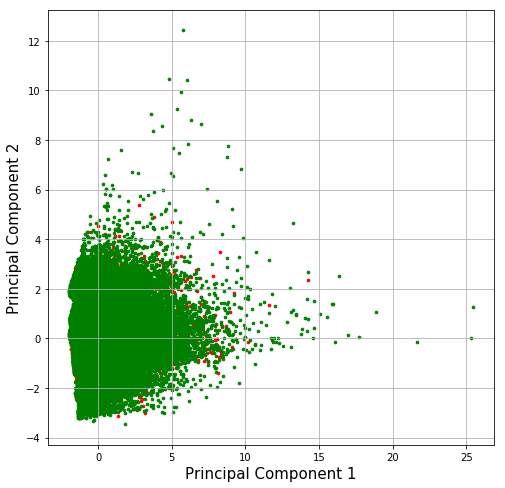

In [13]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

colors = ['r', 'g']

for i, color in enumerate(colors):
    indices = X_pca['cvic'] == (i%2==0)
    ax.scatter(X_pca.loc[indices, 0],
               X_pca.loc[indices, 1],
               c = color,
               s = 7)
ax.grid()
plt.show()

No real cluster discrimination

#### Behavior exploration

Now, we're going to extract some hindsights from the nature of the visited pages

In [14]:
logged_sessions = sessions[lambda df: df.client_number.notnull()].drop_duplicates()

In [15]:
%%time

import ast
funnel = logged_sessions['funnel'].progress_apply(lambda s: pd.Series(ast.literal_eval(s)).value_counts())

100%|██████████| 152009/152009 [03:06<00:00, 817.06it/s] 

CPU times: user 3min 3s, sys: 9.14 s, total: 3min 12s
Wall time: 3min 6s


In [16]:
funnel.head()

,login_no_compte_internet,product,soldes,accueil,panier_consult,user_info,panier_ajout,page,user_payment,paiement_cb,...,offre_nouvelle_cliente,offre_courrier,footer,newsletter,catalogue,header,cadeau,catalogue_demande,paiement_cheque,suivi
2,9.0,5.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,5.0,5.0,4.0,2.0,2.0,7.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,4.0,NaN,1.0,4.0,1.0,8.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,4.0,NaN,3.0,3.0,1.0,3.0,3.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,1.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
funnel.to_csv('../data/sessions-funnel.csv.gz', compression='gzip')

**Matrix**

In [18]:
funnel = pd.read_csv('../data/sessions-funnel.csv.gz', index_col=0)

In [19]:
funnel.columns

Index(['login_no_compte_internet', 'product', 'soldes', 'accueil',
       'panier_consult', 'user_info', 'panier_ajout', 'page', 'user_payment',
       'paiement_cb', 'CGV', 'login_no_client', 'livraison', 'category',
       'login_compte_internet', 'recherche', 'login', 'information',
       'offre_nouvelle_cliente', 'offre_courrier', 'footer', 'newsletter',
       'catalogue', 'header', 'cadeau', 'catalogue_demande', 'paiement_cheque',
       'suivi'],
      dtype='object')

Let's normalize everything by the total number of pages viewed

In [20]:
funnel = funnel.fillna(value=0)
funnel[:] = funnel.values / logged_sessions['nb_pages'].values[:, None]

Let's take the 10 most visited pages as features

In [21]:
pages = (funnel != 0).sum(axis=0).sort_values(ascending=False)[:10].index.values

In [22]:
pages

array(['user_info', 'page', 'panier_consult', 'accueil', 'livraison',
       'user_payment', 'product', 'panier_ajout', 'paiement_cb',
       'category'], dtype=object)

**Visualisation**

This time let's add those new features to the mix to see if it allows better discrimination

In [23]:
X = logged_sessions[['nb_pages', 'duration', 'order_date', 'pre_tax_amount']]
y = logged_sessions['cvic']

In [24]:
X['cycle_day'] = np.cos(X['order_date'].dt.dayofyear*(30/365)*2*np.pi)
X['duration'] = X['duration'].dt.total_seconds()
X = X.drop(['order_date'], axis=1)

/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
X = pd.concat([X, funnel.loc[:, pages.tolist()]], axis=1)

In [28]:
X.head()

,nb_pages,duration,pre_tax_amount,cycle_day,user_info,page,panier_consult,accueil,livraison,user_payment,product,panier_ajout,paiement_cb,category
2,35,2117.0,45.00,0.869589,0.057143,0.057143,0.085714,0.085714,0.028571,0.028571,0.142857,0.057143,0.028571,0.028571
6,30,1368.0,146.66,0.869589,0.066667,0.066667,0.066667,0.133333,0.033333,0.033333,0.166667,0.233333,0.033333,0.000000
14,26,1710.0,195.50,0.869589,0.038462,0.038462,0.153846,0.038462,0.038462,0.038462,0.153846,0.307692,0.038462,0.076923
30,30,1689.0,141.59,0.021516,0.033333,0.100000,0.100000,0.100000,0.066667,0.033333,0.133333,0.100000,0.033333,0.200000
71,5,102.0,52.42,-0.474951,0.600000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
X.to_csv('../data/sessions-features.csv.gz', compression='gzip')

In [29]:
X_scaled = StandardScaler(copy=True).fit_transform(X)

In [30]:
pca = PCA(n_components=3)
X_scaled = pd.DataFrame(pca.fit_transform(X_scaled), index=logged_sessions.index)
X_scaled = pd.concat([X_scaled, y], axis=1)

In [31]:
pca.explained_variance_ratio_.sum()

0.4521724734937731

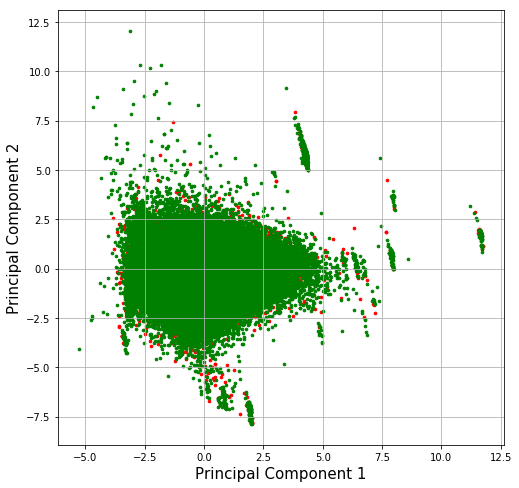

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

colors = ['r', 'g']

for i, color in enumerate(colors):
    indices = X_scaled['cvic'] == (i%2==0)
    ax.scatter(X_scaled.loc[indices, 1],
               X_scaled.loc[indices, 2],
               c = color,
               s = 7)
ax.grid()
plt.show()

Some chunks of data start to be visible

#### Behavior look-alike extrapolation

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
scaler = StandardScaler(copy=True)

In [35]:
scaler.fit(X)
X_scaled = scaler.transform(X)

In [36]:
pca = PCA(n_components=7)
pca.fit(X_scaled)
X_scaled = pca.transform(X_scaled)

In [37]:
pca.explained_variance_ratio_.sum()

0.7358283561165253

In [38]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_scaled, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

We get the indices of the PIO order sessions in order to use our model against those.

In [39]:
pio_sessions = logged_sessions[lambda df: ~df.cvic & df.client_number.notnull()].copy()

In [40]:
X_pio_scaled = scaler.transform(X.loc[pio_sessions.index])
X_pio_scaled = pca.transform(X_pio_scaled)

In [41]:
pio_sessions['predicted_cvic'] = knn.predict(X_pio_scaled)

In [42]:
pio_sessions['predicted_cvic'].sum()

4063

According to this method, 4063 converted web sessions seem to follow the same pattern as IMO web sessions.

**What are the characteristics of those sessions ?** 

Let's compare some metrics between true PIO and false PIO sessions 

In [44]:
pio_sessions['type'] = np.where(pio_sessions.cvic != pio_sessions.predicted_cvic, 'False PIO', 'True PIO')

In [45]:
pio_sessions.groupby('type')[['nb_pages']].mean()

,nb_pages
type,
False PIO,26.351218
True PIO,32.067858


Customers coming from the catalog have shorter visit paths

In [46]:
pio_sessions['duration'] = pio_sessions['duration'].dt.total_seconds()

In [47]:
pio_sessions.groupby('type')[['duration']].mean() / 60

,duration
type,
False PIO,22.491377
True PIO,25.186272


As a result, they tend to spend less time on the website

**Reconciliation**

In [48]:
logged_sessions['predicted_cvic'] = logged_sessions['cvic'].combine(pio_sessions['predicted_cvic'], lambda x, y: y if y else x)

In [49]:
logged_sessions['type'] = np.where((logged_sessions.cvic != logged_sessions.predicted_cvic) & (logged_sessions.cvic == False), 
                                   'False PIO', 'True PIO')
logged_sessions.loc[logged_sessions.cvic, 'type'] = 'IMO'

In [50]:
logged_sessions.groupby('type')[['nb_pages']].mean()

,nb_pages
type,
False PIO,26.351218
IMO,29.562794
True PIO,32.067858


In [51]:
logged_sessions['duration'] = logged_sessions['duration'].dt.total_seconds()
logged_sessions.groupby('type')[['duration']].mean() / 60

,duration
type,
False PIO,22.491377
IMO,24.567939
True PIO,25.186272


In [52]:
logged_sessions.groupby('type')[['pre_tax_amount']].mean()

,pre_tax_amount
type,
False PIO,93.460674
IMO,94.153398
True PIO,91.797008


/Users/JEP/.pyenv/versions/3.6.6/envs/eleven-classif/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


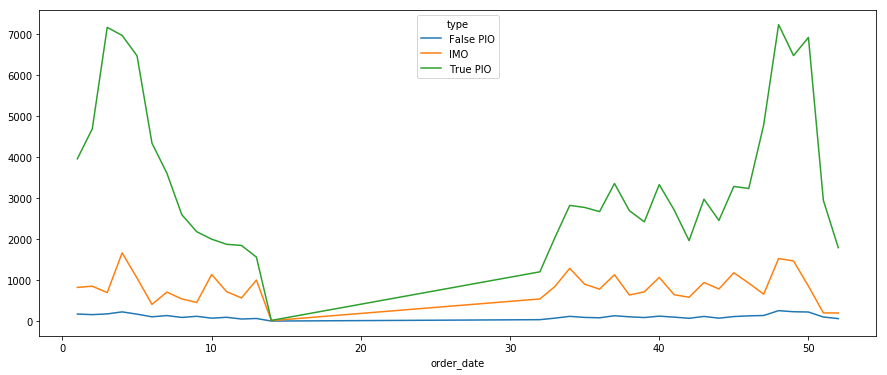

In [53]:
logged_sessions.groupby((logged_sessions.order_date.dt.week, 'type')).count()['session_id'].unstack().plot(figsize=(15,6))

In [54]:
logged_sessions.to_csv('../sessions_with_corrected_cvic.csv.gz', compression='gzip')

In [84]:
sessions['cvic'] = logged_sessions['predicted_cvic']

In [86]:
(sessions.cvic == False).sum() / len(sessions)

0.026421148775798722

In [82]:
logged_sessions['predicted_cvic']

2          False
6          False
14          True
30         False
71          True
73         False
89         False
130        False
134        False
140        False
164        False
166        False
169         True
182        False
255         True
258        False
265         True
273         True
293        False
332        False
391        False
432        False
438         True
464         True
513        False
514         True
525         True
531        False
574         True
596         True
           ...  
4519088    False
4519192     True
4519216    False
4519370     True
4519385     True
4519443    False
4519457     True
4519498    False
4519569    False
4519597     True
4519605     True
4519607    False
4519638     True
4519762     True
4519782    False
4519788     True
4519859    False
4519932    False
4519942     True
4520028     True
4520067    False
4520158     True
4520233     True
4520237     True
4520264     True
4520302     True
4520406    False
4520464    Fal

**Partial dependance plot**

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

In [77]:
clf = GradientBoostingRegressor(n_estimators=150, max_depth=8,
                                learning_rate=0.1, loss='huber',
                                random_state=1)
clf.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=8,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=150,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False)

(<Figure size 1080x1080 with 9 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x16f4222e8>])

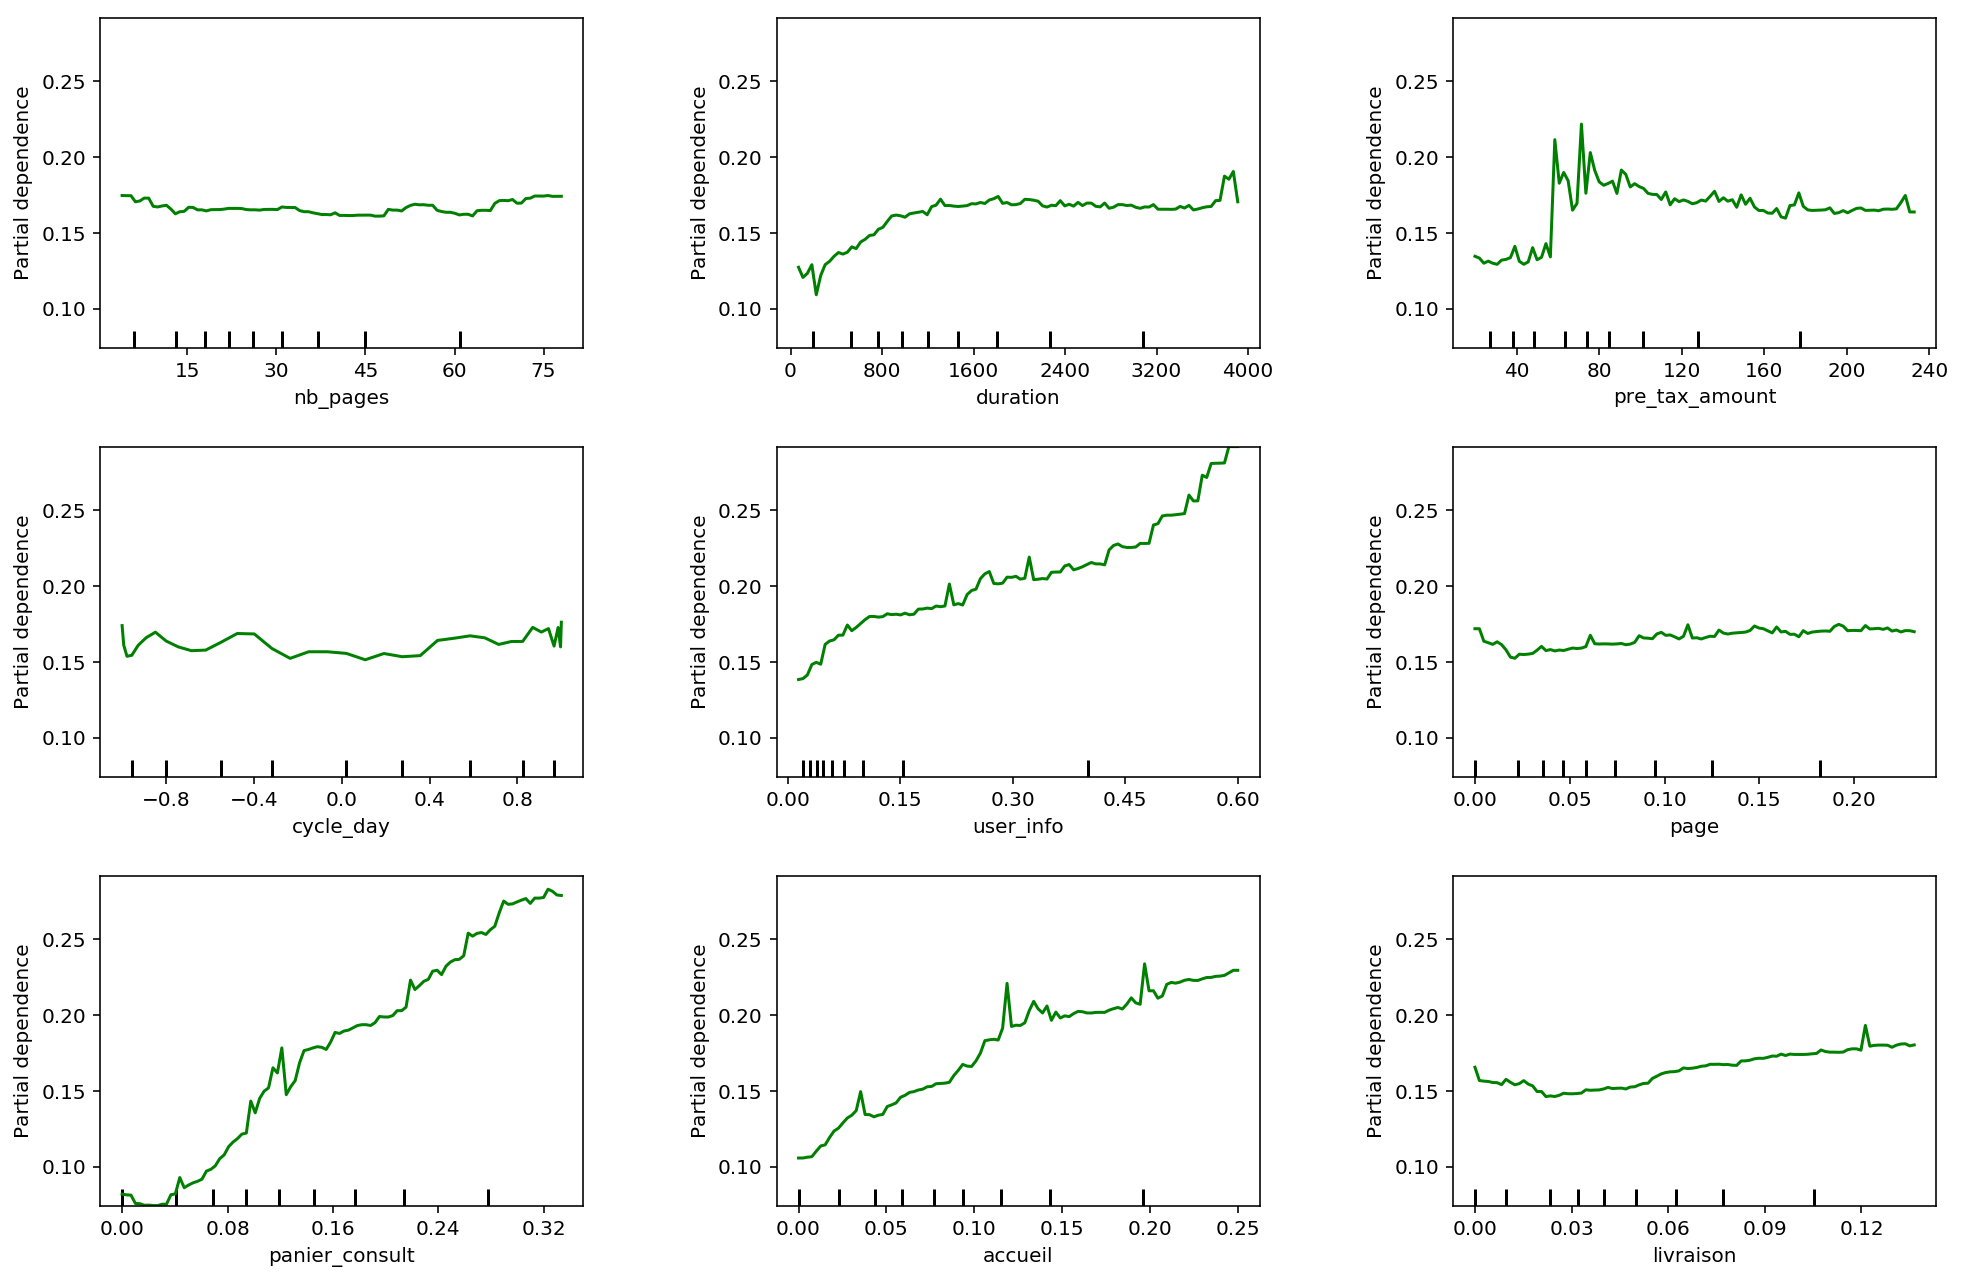

In [80]:
plot_partial_dependence(clf, X, features=[0,1,2,3,4,5,6,7,8], feature_names=X.columns, figsize=(15, 15))